# Прогнозирование оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Цель проекта</b> - предсказать намерение клиента отказаться от услуг оператора связи для своевременного предложения стимулирующих бонусов.

<b>Задача проекта</b> - построить прототип модели машинного обучения способной достичь метрики AUC-ROC больше 0.85.
  

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:
- <i>contract_new.csv</i> информация о договоре;
- <i>personal_new.csv</i> персональные данные клиента;
- <i>internet_new.csv</i> информация об интернет услугах;
- <i>phone_new.csv</i> информация об услугах телефонии.

Значения признаков:
- <i>BeginDate</i> - дата начала пользования услугами;
- <i>EndDate</i> - дата окончания пользования услугами;
- <i>Type</i> - тип оплаты: ежемесячный, годовой и тд;
- <i>PaperlessBilling</i> - безналичный расчет;
- <i>PaymentMethod</i> - способ оплаты;
- <i>MonthlyCharges</i> - ежемесячные траты на услуги;
- <i>TotalCharges</i> - всего потрачено денег на услуги;
- <i>Dependents</i> - наличие иждивенцев;
- <i>Senior</i> - Citizen наличие пенсионного статуса по возрасту;
- <i>Partner</i> - наличие супруга(и);
- <i>MultipleLines</i> - наличие возможности ведения параллельных линий во время звонка.


<b>План проекта</b> 
1. Загрузка и изучение данных;
2. Предобработка данных:
   - объединить датасеты;
   - преобразовать типы данных;
   - исследовать аномалии и заполнить пропуски;
   - удалить дублирующиеся по информативности столбцы; 
   - преобразовать категориальные признаки в числовые;
   - сгенерировать синтетические признаки;
   - сгенерировать целевой признак.
3. Исследовательский анализ данных:
   - исследовать баланс классов;
   - исследовать корреляцию признаков и целевого столбца;
   - провести группировки и визуализацию признаков для определения зависимостей;
   - провести сравнение данных по активным и ушедшим пользователям.
4. Обучение моделей:
   - разделить датасет на тренировочный и тестовый;
   - построить пайплайны, включающие масштабирование, кодирование и обучение для моделей случайного леса и градиентного бустинга;
   - подбор гиперпараметров для моделей;
   - оценка целевой метрики на кросс-валидации.
5. Тестирование лучшей модели:
   - оценка целевой метрики;
   - оценка важности признаков.
6. Выводы

# Загрузка и изучение данных

In [1]:
#загрузим необходимые библиотеки

import warnings

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    f1_score, 
    precision_score, 
    recall_score, 
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV,
    KFold
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

# натроим некоторые параметры
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

#зададим константу
RANDOM_STATE = 240423

In [2]:
#Создадим функцию для загрузки датасетов
def read_df(df):
    if os.path.exists('/datasets/'+df):
        df_raw = pd.read_csv('/datasets/'+df)
        print('platform')
    else:
        df_raw = pd.read_csv(df)
        print('remote')
    return df_raw    

In [3]:
#Выполним загрузку данных
df_contract = read_df('contract_new.csv')
df_personal = read_df('personal_new.csv')
df_internet = read_df('internet_new.csv')
df_phone = read_df('phone_new.csv')

remote
remote
remote
remote


In [4]:
#создадим функцию для вывода обзорного отчета по данным
def mini_report(df):
    print('Head')
    display(df.head())
    print('')
    print('Describe')
    display(df.describe())
    print('')
    display(df.info())
    print('Всего пропущенных значений %', 
          pd.DataFrame(df.isna().mean()*100).sum())

In [5]:
# получим отчет по первому датасету
mini_report(df_contract)

Head


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Describe


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Всего пропущенных значений % 0    0.0
dtype: float64


Для первого датасета с данными о клиенте необходимо преобразование типов данных. Сейчас численные значения и даты представлены в формате object что затрудняет анализ. Аномалии будут исследованы после преобразование типа данных. Пропущенных значений здесь нет. Дубликаты будут исследованы после объединения датасетов.

In [6]:
# получим отчет по датасету с личными данными клиента
mini_report(df_personal)

Head


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Describe


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Всего пропущенных значений % 0    0.0
dtype: float64


Для датасета personal также требуется преобразование типов данных. Все признаки представляют собой категории (причем категории всего две). Такие данные будут преобразованы в численные 0 и 1. Пропуски также отсуствуют. Количество строк здесь совпадает с предыдущим датасетом df_contract.

In [7]:
#далее посмотрим на данные об использовании интернета
mini_report(df_internet)

Head


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Describe


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Всего пропущенных значений % 0    0.0
dtype: float64


Рассмотренный выше датасет имеет только признаки с двумя уникальными категориями. Категории будут преобразованы в числовые для удобства. Можно сделать вывод, что не все клиенты оператора связи пользуются услугами интернета.

In [8]:
#получим отчет о пользователях телефонии
mini_report(df_phone)

Head


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Describe


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Всего пропущенных значений % 0    0.0
dtype: float64


Датасет phone содержит только уникальный идентификатор клиента и факт использования параллельных линий во время звонка. Категории здесь также будут преобразованы в 0 и 1. Не все клиенты оператора связи пользуются телефонией, поскольку количество строк не совпадает с преддыдущими датасетами.

Все изученные датасеты содержат столбец customerID с уникальным индентификатором клиента. По этому признаку будет выполнено объединение данных для более удобной работы в дальнейшем.

# Предобработка данных

In [9]:
# объединим датасеты
df_1 = pd.merge(df_contract, df_personal, how='left', on='customerID')
df_2 = pd.merge(df_1, df_internet, how='left', on='customerID')
df_raw = pd.merge(df_2, df_phone, how='left', on='customerID')

Далее убедимся, что слияние прошло корректно.

In [10]:
#Вывод итоговой таблицы
df_raw

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [11]:
#проверим количество пропусков
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Далее приступим к заполнению пропусков. Пропущенные значения в столбце InternetService можно заполнить значением Unknown, поскольку в этой таблице нет данных для всех пользователей оператора. 

In [12]:
# заполним пропуски в категориальном столбце
df_raw['InternetService'] = df_raw['InternetService'].fillna(value='Unknown')

При попытке преобразовании типа данных в столбце TotalCharges были обнаружены пробелы вместо значений. Данных в этом столбце нет для пользователей, которые стали клиентами оператора в день выгрузки базы данных. Поэтому заполним пропущенные значения суммой ежемесячного платежа, посколку новыми клиентами и был совершен только один платеж.

In [13]:
# выделем данные с пропусками в отдельный датафрейм
missing = df_raw[df_raw['TotalCharges'] == ' ']
missing

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [14]:
# заполняем пропуски значениями из MonthlyCharges
df_raw['TotalCharges'] =  np.where(df_raw['TotalCharges']==' ', 
                          df_raw['MonthlyCharges'], df_raw['TotalCharges'])

In [15]:
# проверим корретность заполнения пропусков
check = df_raw[df_raw.index.isin(missing.index)]
check

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.0,Female,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.7,Male,0,Yes,Yes,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [16]:
#преобразуем колонку из объектного типа в числовой
df_raw['TotalCharges'] = df_raw['TotalCharges'].astype(float)

Далее проверим характер распределения значений в чистовых столбцах и наличие выборосов.

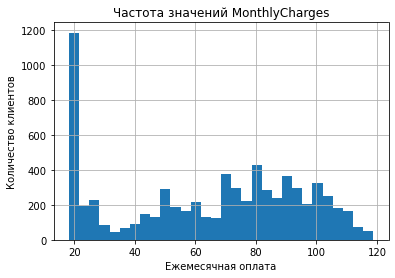

In [17]:
#выведем частотную диаграмму для MonthlyCharges
df_raw['MonthlyCharges'].hist(bins=30)

plt.xlabel('Ежемесячная оплата')
plt.ylabel('Количество клиентов')
plt.title('Частота значений MonthlyCharges');

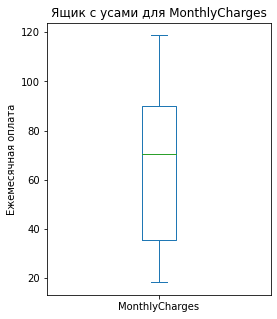

In [18]:
#также отобразим выбросы
df_raw['MonthlyCharges'].plot(kind='box', figsize=(4,5))

plt.ylabel('Ежемесячная оплата')
plt.title('Ящик с усами для MonthlyCharges');

Значения в столбце MonthlyCharges имеют нормальное распределение. Видно, что большинство клиентов пользуются недорогим тарифом (месячная оплата около 20 у.е.). В этих данных также нет выборосов.

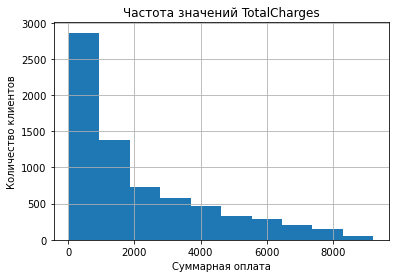

In [19]:
#выведем частотную диаграмму для TotalCharges
df_raw['TotalCharges'].hist()

plt.xlabel('Суммарная оплата')
plt.ylabel('Количество клиентов')
plt.title('Частота значений TotalCharges');

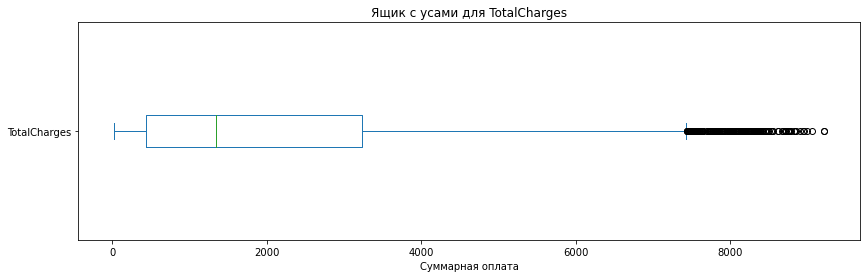

In [20]:
#выведем диаграмму boxplot
df_raw['TotalCharges'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Суммарная оплата')
plt.title('Ящик с усами для TotalCharges');

Распределение данных в столбце TotalCharges смещено вправо. Кроме того, есть выбросы в районе максимального значения. Эти данные будут сохранены, чтобы не терять информацию. Для того, чтобы выбросы не повлияли на обучение модели, будет использован метод масштабирования, не привязанный к средним значениям.

Далее заполним пропуски в значениях, полученные при слиянии датафреймов. Эти пропуски связаны с отсутвием данных о клиентах, поэтому заколним их 0 - то есть, клиент не пользуется услугой. 

In [21]:
#создадим список столбцов для преобразования 
col_trans = ['PaperlessBilling', 'Partner', 
             'Dependents', 'OnlineSecurity', 
             'OnlineBackup', 'DeviceProtection', 
             'TechSupport', 'StreamingTV', 
             'StreamingMovies', 'MultipleLines']

#циклом заменим значения, заодно и пропуски заполним
for col in col_trans:
    df_raw[col] = df_raw[col].fillna(value=0)

In [22]:
#далее преобразуем типы данных для столбца с датой
df_raw['BeginDate'] =  pd.to_datetime(df_raw['BeginDate'])

In [23]:
#преобразуем столбец с указанием пола клиента
df_raw['gender'] = df_raw['gender'].map({'Female': 1, 'Male': 0})

Далее создадим целевой столбец. В столбце EndDate содержатся даты, когда клиенты прекращали пользоваться услугами оператора. Таким образом, можно заполнить значение с датой на 1 - то есть клиент ушел и значение No на 0, то есть, клиент продолжает пользоваться услугами.

In [24]:
#создадим целевой столбец
df_raw['Exited'] =  np.where(df_raw['EndDate']=='No', 0, 1)
df_raw['Exited'].unique()

array([0, 1])

Далее необходимо создать переходный столбец с зафиксированной датой выгрузы базы данных. Таким образом, у действющих клиентов дата зафиксируется на 2020-02-01, а для ушедших клиентов останется дата прекращения договора. Таким образом можно вычислить срок пользования клиентами услуг оператора, это может стать важным признаком.

In [25]:
#создадим новый стобец и заменим значения
df_raw['EndDateFact'] =  np.where(df_raw['EndDate']=='No', '2020-02-01', df_raw['EndDate'])
#преобразуем тип данных на временной
df_raw['EndDateFact']= pd.to_datetime(df_raw['EndDateFact'])

#создадим новый столбец с количеством дней пользования услугами
df_raw['Duration'] = (df_raw['EndDateFact'] - df_raw['BeginDate']).dt.days

Также создадим столбец с предположительным составом семьи. Используем его для вычисления стоимости услуг на одного человека в семье.

In [26]:
#создадим столбец с предположительным составом семьи
df_raw['Family'] = df_raw['Partner'] + df_raw['Dependents'] + 1

Далее создадим дополнительный признак, где зафиксируем стоимость услуг оператора на одного члена семьи.

In [27]:
# создадим столбец с платежом на целовека
df_raw['PaymentPerMember'] = df_raw['MonthlyCharges'] / df_raw['Family']

Далее создадим новый датасет только с нужными столбцам. Здесь необходимо удалить столбцы с датами, чтобы не произошла утечка данных. 

In [28]:
#создадим новый датасет только с нужными столбцам
df = df_raw.drop(['customerID', 'BeginDate', 'EndDate', 'EndDateFact', 'Family'], axis=1)
df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Exited,Duration,PaymentPerMember
0,Month-to-month,1,Electronic check,29.85,31.04,1,0,1,0,DSL,0,1,0,0,0,0,0,0,31,14.925000
1,One year,0,Mailed check,56.95,2071.84,0,0,0,0,DSL,1,0,1,0,0,0,0,0,1036,56.950000
2,Month-to-month,1,Mailed check,53.85,226.17,0,0,0,0,DSL,1,1,0,0,0,0,0,0,123,53.850000
3,One year,0,Bank transfer (automatic),42.30,1960.60,0,0,0,0,DSL,1,0,1,1,0,0,0,0,1371,42.300000
4,Month-to-month,1,Electronic check,70.70,353.50,1,0,0,0,Fiber optic,0,0,0,0,0,0,0,0,153,70.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,1,Mailed check,84.80,2035.20,0,0,1,1,DSL,1,0,1,1,1,1,1,0,730,28.266667
7039,One year,1,Credit card (automatic),103.20,7430.40,1,0,1,1,Fiber optic,0,1,1,0,1,1,1,0,2191,34.400000
7040,Month-to-month,1,Electronic check,29.60,325.60,1,0,1,1,DSL,1,0,0,0,0,0,0,0,337,9.866667
7041,Month-to-month,1,Mailed check,74.40,520.80,0,1,1,0,Fiber optic,0,0,0,0,0,0,1,0,215,37.200000


In [29]:
#проверим, что датасет готов
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null   int64  


В результате преобработки данных были объединены датасеты, преобразованы типы данных, заполнены пропуски и исследованы аномалии в числовых столбцах. Кроме того, были сгенерированы новые признаки и целевой признак. Из итогового датасета были удалены столбцы с датами, поскольку они могут стать причиной утечки данных. Вместо них создан признак Duration с числом дней, которые клиент пользовался услугами оператора.


# Исследовательский анализ данных

0    0.843675
1    0.156325
Name: Exited, dtype: float64


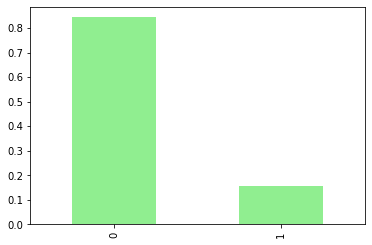

In [29]:
#исследуем баланс классов

#относительная частота значений от 0 до 1
class_frequency = df['Exited'].value_counts(normalize=True)

#выведем относительное количество данных в двух классах
print(class_frequency)

#для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='lightgreen');

Количество действующих клиентов в несколько раз больше числа ушедших, что логично. Дисбаланс классов будет учтен при обучении.

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Exited', 'Duration', 'PaymentPerMember']


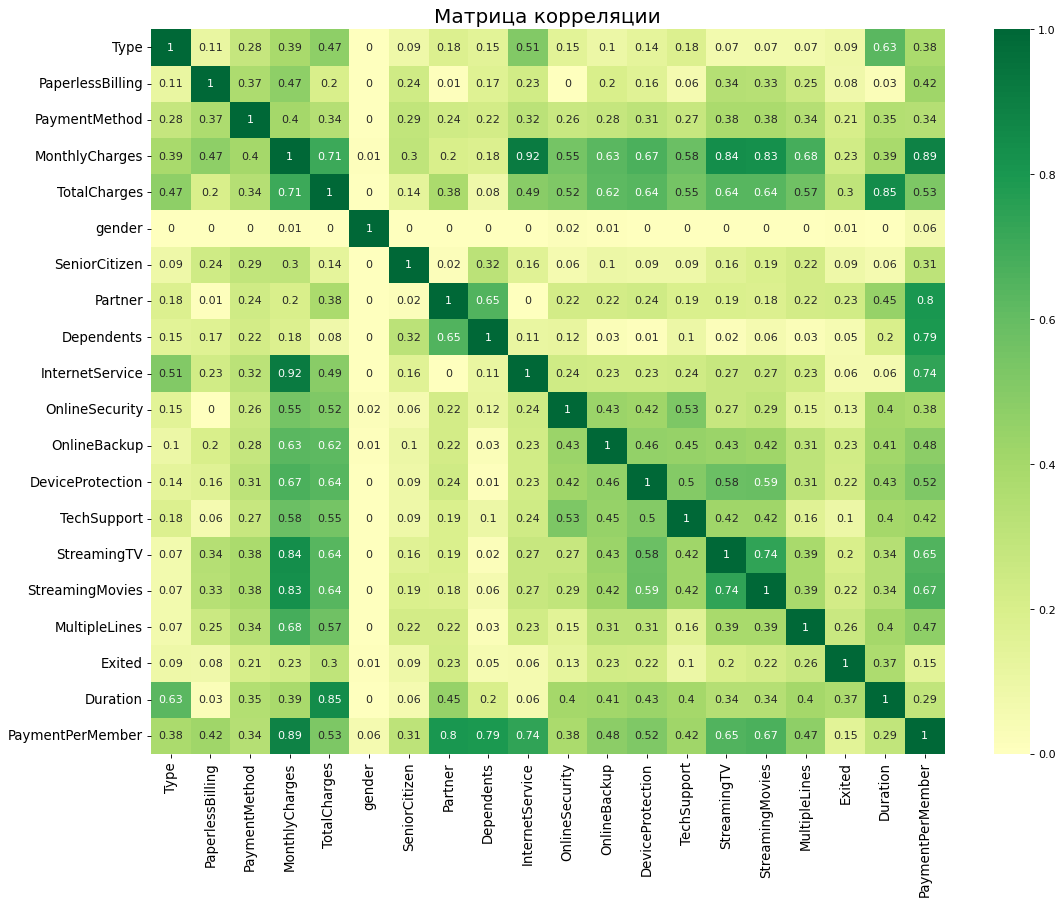

In [30]:
#отобразим матрицу корреляции для всех признаков

plt.figure(figsize=(16,12), dpi= 80)

sns.heatmap(df.phik_matrix().round(2),
            xticklabels=df.columns, 
            yticklabels=df.columns, 
            cmap='RdYlGn', 
            center=0, 
            annot=True)

#выведем результат
plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
None

Наблюдается слабая корреляция признаков с целевым признаком Exited. Практически ничего на него не влияет. Признак gender слабее всего оказывает влияние на признаки. Для некоторых признаков наблюдается мультиколлинеарность. Эти столбцы будут сохранены, поскольку для обучения будут использованы модели не чувствительные к мультиколлинераности.

Далее посмотрим, сколько клиентов стало клиентами оператора по годам.

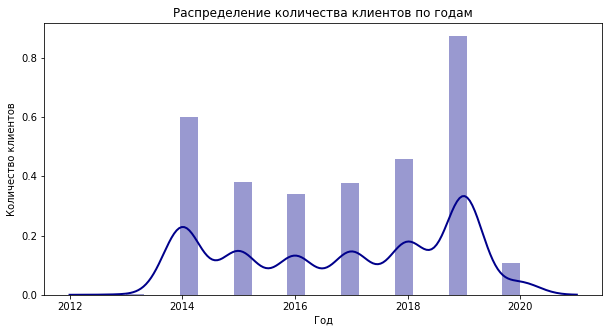

In [31]:
#выведем частотную диаграмму по годам
plt.figure(figsize=(10,5))
sns.distplot(df_raw['BeginDate'].dt.year,  
             hist=True,
             bins=22, 
             color = 'darkblue', 
             kde_kws={'linewidth': 2})

plt.xlabel('Год')
plt.ylabel('Количество клиентов')
plt.title('Распределение количества клиентов по годам');

Посмотрим, в какие года больше всего клиентов покинуло оператора. Для этого сделаем промежуточную таблицу с данными только ушедших клиентов и преобразуем значения.

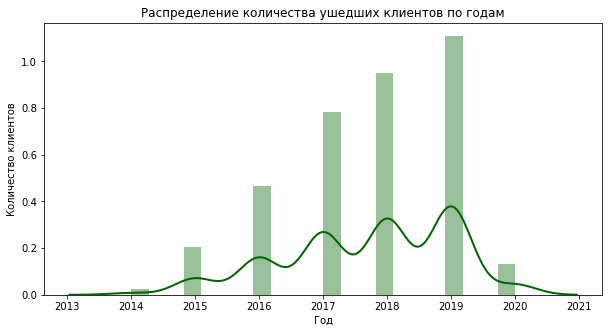

In [32]:
#создадим таблицу с активными клиентами
active_clients = df_raw[df_raw['EndDate'] != 'No']
active_clients['EndDate'] =  pd.to_datetime(active_clients['EndDate'])

#выведем частотную диаграмму по годам
plt.figure(figsize=(10,5))
sns.distplot(active_clients['EndDate'].dt.year,  
             hist=True,
             bins=22, 
             color = 'darkgreen', 
             kde_kws={'linewidth': 2})

plt.xlabel('Год')
plt.ylabel('Количество клиентов')
plt.title('Распределение количества ушедших клиентов по годам');

Больше всего новых клиентов появилось в 2019 году. В этом же году ушло наибольшее количество клиентов. На первой диаграмме есть два пика, когда подключилось большое число клиентов - 2014 и 2019 года. На второй диаграмме данные распределены более равномерно, с каждым годом уходит все больше клиентов. За 2020 данные неполные, поэтому можно не брать во внимание "спад".

Посмотрим, как наличие партнера и иждивенцев влияет на отток клиентов.

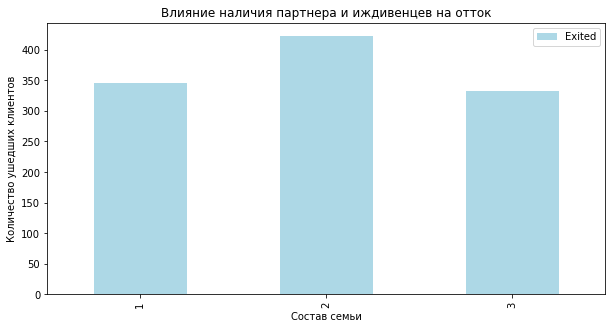

In [33]:
#создаим сводную таблицу с группировкой по составу семьи
t = (df_raw.pivot_table(index='Family', values='Exited', aggfunc='sum')
      .plot(kind='bar', figsize= (10,5), color='lightblue'));

plt.xlabel('Состав семьи')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние наличия партнера и иждивенцев на отток');

Среди ушедших клиентов наибольшее количество составляют те, у кого есть партнер и нет иждивенцев (предположительно, детей). Далее посмотрим, как распределен пенсионный статус среди ушедших клиентов.

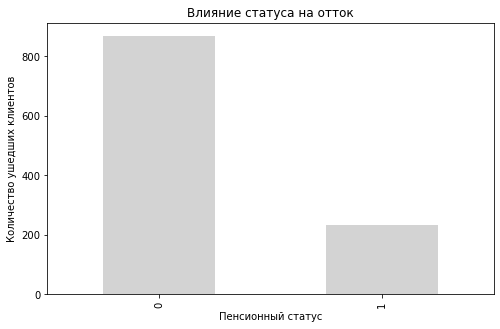

In [34]:
#сгруппируем данные по статусу и вычислим количество ушедших клиентов
t = (df.groupby('SeniorCitizen')['Exited'].sum()
     .plot(kind='bar', 
           figsize= (8,5), 
           color='lightgrey'))

plt.xlabel('Пенсионный статус')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние статуса на отток');

Пенсионеров среди ушедших клиентов меньшинство. Посмотрим также на гендерный состав ушедших клиентов.

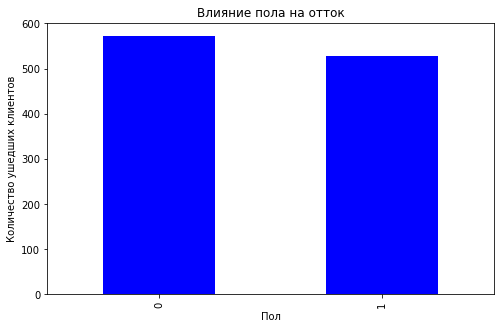

In [35]:
#сгруппируем данные ушедших клиентов по гендеру
(df.groupby('gender')['Exited'].sum()
 .plot(kind='bar', 
       figsize= (8,5), 
       color='blue'))

plt.xlabel('Пол')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние пола на отток');

Гендерный состав ушедших клиентов почти равен. Проанализируем распределение клиентов с разными типами подписок.

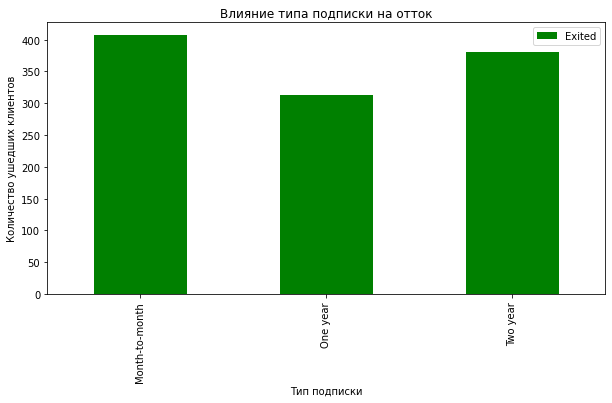

In [36]:
#сгруппируем ушедших клиентов по типу подписки
t = (df.pivot_table(index='Type', values='Exited', aggfunc='sum')
      .plot(kind='bar', figsize= (10,5), color='green'));

plt.xlabel('Тип подписки')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние типа подписки на отток');

Среди ушедших клиентов больше тех, кто приобретал месячную подписку. Немного меньше тех, кто был приобретал подписку на два года.

Далее посмотрим сколько какое распределение количества дней, когда пользователь был клиентом оператора. Выберем только те значения, которые превышают максимальную цену ежемесячного списания чтобы отсеч тех, кто является клиентом короткий срок.

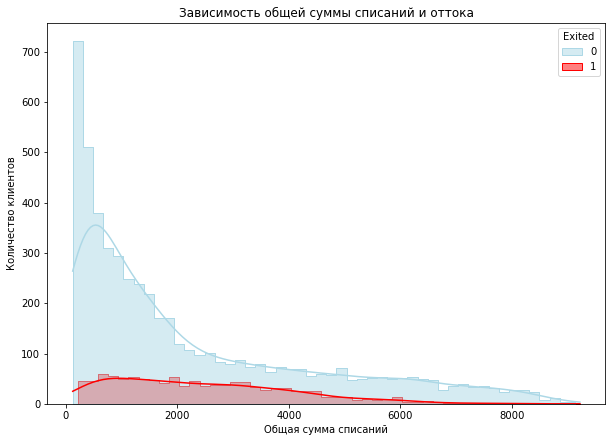

In [37]:
#зададим размер диаграммы
plt.figure(figsize=(10,7))

#задаим параметры диаграммы
sns.histplot(data=df.query('TotalCharges > 120'), 
             x='TotalCharges', 
             hue='Exited', 
             multiple='dodge', 
             palette = ('lightblue', 'red'),
             kde=True,
             bins=50,
             element='step')

plt.xlabel('Общая сумма списаний')
plt.ylabel('Количество клиентов')
plt.title('Зависимость общей суммы списаний и оттока');

Наибольшее количество клиентов, покинувших оператора заплатило за весь период активности около 700 у.е. Дальше посмотрим, как факт пользования услугами интернета влияет на отток клиентов.

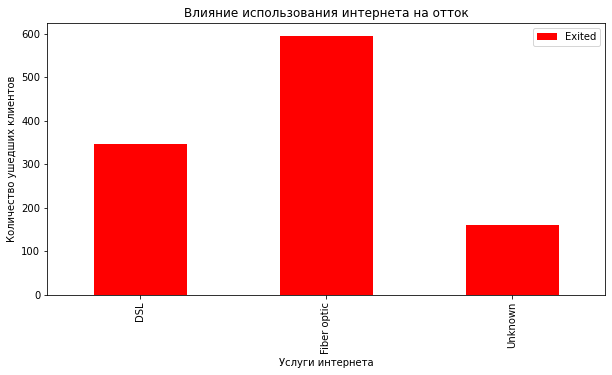

In [38]:
#сгруппируем данные по столбцу InternetService
t = (df.pivot_table(index='InternetService', values='Exited', aggfunc='sum')
      .plot(kind='bar', figsize= (10,5), color='red'));

plt.xlabel('Услуги интернета')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние использования интернета на отток');

Большее количество ушедших клиентов использовало современный интернет. Меньше всего ушедших клиентов вообще не пользовались услугами интернета. Далее проанализируем, сколько клиентов пользовались услугами телефонии.

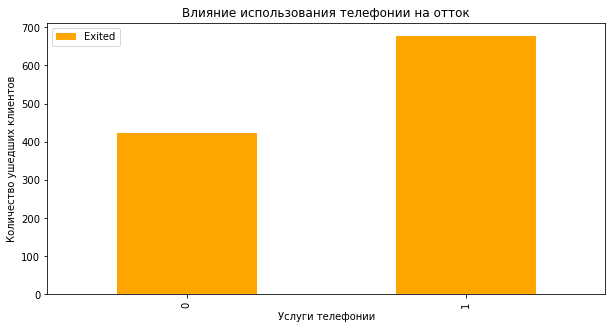

In [39]:
#сгруппируем данные по MultipleLines и выведем диаграмму
t = (df.pivot_table(index='MultipleLines', values='Exited', aggfunc='sum')
      .plot(kind='bar', figsize= (10,5), color='orange'));

plt.xlabel('Услуги телефонии')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние использования телефонии на отток');

Клиентов, которые использовали многоканальную телефонию и решили сменить оператора связи, больше. Следующим шагом посмотрим сколько какое распределение количества дней, когда пользователь был клиентом оператора.

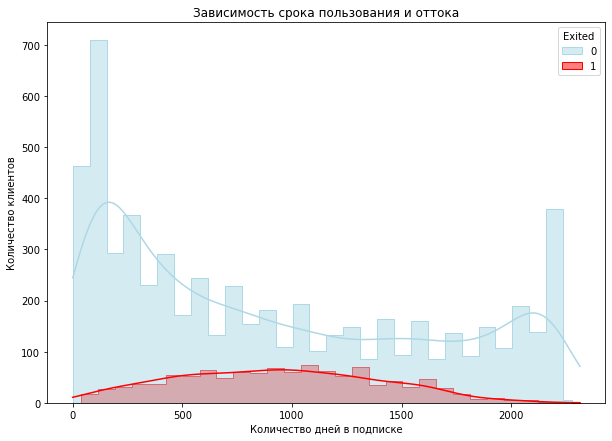

In [40]:
#задаем размер диаграммы
plt.figure(figsize=(10,7))

#задаем параметры диаграммы
sns.histplot(data=df, 
             x='Duration', 
             hue='Exited', 
             multiple='dodge', 
             palette = ('lightblue', 'red'),
             kde=True,
             bins=30,
             element='step')

plt.xlabel('Количество дней в подписке')
plt.ylabel('Количество клиентов')
plt.title('Зависимость срока пользования и оттока');

Среди ушедших клиентов наибольшее количество пользовалось услугами оператора около 1000 дней. Выходит, что ушедшие клиенты довльно долго пользовались услугами, прежде чем принять решение уйти. Далее выведем диаграмму распределения типа оплаты услуг для всех клиентов. 

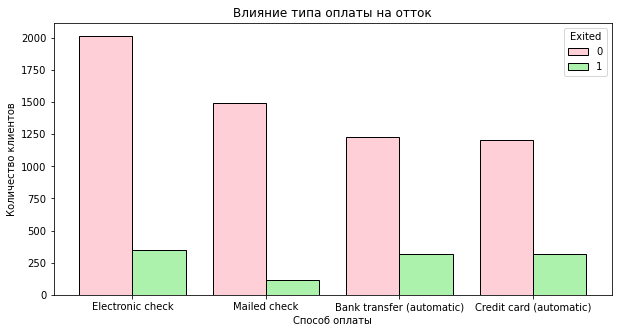

In [41]:
#зададим размер диаграммы
plt.figure(figsize=(10,5))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='PaymentMethod', 
             hue='Exited', 
             multiple='dodge', 
             palette = ('pink', 'lightgreen'), 
             shrink=.8)

plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.title('Влияние типа оплаты на отток');

Меньше всего клиентов отказались от услуг оператора среди тех, кто пользуется почтовым переводом. Далее посмотрим, какое количество ушедших клиентов пользовалось элеметронными чеками.

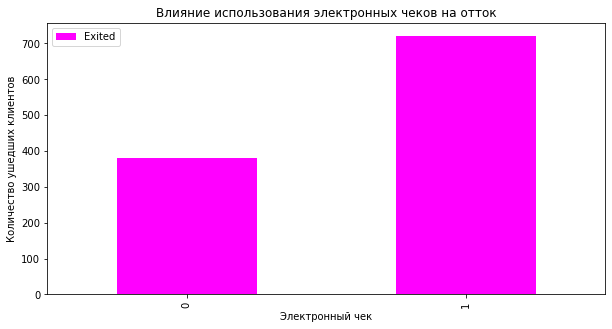

In [42]:
# сгруппируем данные по PaperlessBilling
t = (df.pivot_table(index='PaperlessBilling', values='Exited', aggfunc='sum')
      .plot(kind='bar', figsize= (10,5), color='magenta'));

plt.xlabel('Электронный чек')
plt.ylabel('Количество ушедших клиентов')
plt.title('Влияние использования электронных чеков на отток');

Количество клиентов, использовавших электронные чеки, гораздо больше среди ушедших.

Исследовав исходные данные можно составить портрет клиента, решившего отказаться от услуг оператора:
- мужчина, с парнером, без иждивенцев, не пенсионного возраста;
- является давним клиентом оператора (2-3 года);
- пользуется тарифом с ежемесячной оплатой;
- пользуется скоростным интернетом и многоканальной телефонией;
- предпочитает электронный чеки, а в качестве способа оплаты автоматический бансковский перевод или списание с кредитной карты.

В дальнейшем эти предположения можно сформулировать в гипотезы.

# Обучение моделей

На данном этапе необходимо разделить выборку и обучить модели на лучших гиперпараметрах.

In [30]:
#разделим выборку
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [31]:
#посмотрим на результат деления
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5282, 19)
(5282,)
(1761, 19)
(1761,)


In [32]:
#зададим метрики, которые будут вычисляться для всех моделей
scorers = {
    'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True),
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)
}

In [33]:
#создадим список названий столбцов для кодирования
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['Type', 'PaymentMethod', 'InternetService']


In [34]:
#создадим список столбцов для масштабирования
num_features = ['MonthlyCharges', 'TotalCharges', 'PaymentPerMember', 'Duration']

Создадим транформер для кодирования категориальных и масштабирования численных признаков. Хоть не все модели чувствительны к масштабированию, в целях экономии времени трансформер будет один для всех.

In [48]:
#создадим трансформер для всех моделей
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

In [49]:
#зададим параметр для генерации валидационных выборок
kf = KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

Первым шагом обучим модель логистическая регрессия.

In [50]:
#объявим саму модель
model_lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE)

#создадим пайплайн для нмодели
pipline_lr = make_pipeline(col_transformer, model_lr)

#зададим параметры перебора параметров
param_grid_lr = {'logisticregression__C': [0.1, 0.2, 0.3, 1, 10]}

gs_lr = GridSearchCV(estimator=pipline_lr, 
                     cv=kf, 
                     param_grid=param_grid_lr,
                     refit='roc_auc_score',
                     scoring=scorers,
                     n_jobs=-1)

#обучим модель
gs_lr.fit(X_train, y_train)

gs_lr_best_score = gs_lr.best_score_ 
gs_lr_best_params = gs_lr.best_params_

#выведем результаты обучения
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 0.7727033912930278
best_params: {'logisticregression__C': 10}


In [51]:
#зададим функцию для вывода интересующих метрик

def results_gm(model):
    
    results = pd.DataFrame(model.cv_results_)
    table_results = (results[['mean_test_f1_score', 'mean_test_roc_auc_score', 
                    'mean_test_precision_score', 'mean_test_recall_score']].round(3).head(5)
                     .sort_values(by='mean_test_roc_auc_score', ascending=False))
    
    return table_results

In [52]:
#сохраним результаты в таблице и выведем результаты
tadle_results_lr = results_gm(gs_lr)

tadle_results_lr

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
3,0.423,0.773,0.305,0.691
4,0.420,0.773,0.303,0.688
1,0.425,0.772,0.307,0.692
2,0.422,0.772,0.304,0.691
0,0.425,0.771,0.306,0.694


Далее оценим влияние признаков на целевой, чтобы при доработке лучшей модели можно было отказаться от менее значимых.

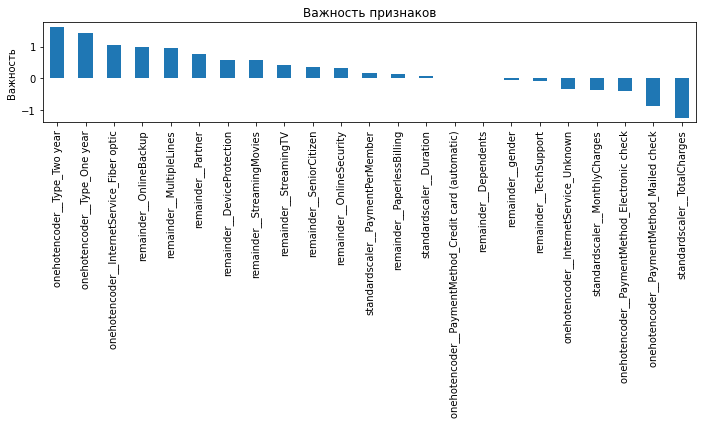

In [53]:
#Зафитим тренировочный датасет,чтобы получить названия столбцов
X_train_col = X_train.copy()
col_transformer.fit(X_train_col)

#определим финальную модель и выведем результаты
model_lr = gs_lr.best_estimator_._final_estimator
imp = pd.Series(model_lr.coef_[0],
               pipline_lr[:-1].get_feature_names_out())

fig, ax = plt.subplots(figsize=(10,6))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Наибольшее влияние на целевой признак оказывают типы подписок (два года и год), а также факт использования скоростного интернета. Это похоже на результаты исследования типичного пользователя, решившего покинуть оператора.

Далее обучим модель случайный лес и также оценим важность признаков.

In [54]:
#объявим саму модель
model_rf = RandomForestClassifier(class_weight='balanced', n_estimators=300, random_state=RANDOM_STATE)

#создадим пйплайн для нмодели
pipline_rf = make_pipeline(col_transformer, model_rf)

#зададим параметры перебора параметров
param_grid_rf = {
    'randomforestclassifier__max_depth': range(2, 18),
    'randomforestclassifier__min_samples_split': [2, 4, 6, 8, 10],
    'randomforestclassifier__min_samples_leaf': [8, 16, 20, 24, 32]
}

gs_rf = RandomizedSearchCV(estimator=pipline_rf, 
                     cv=kf, 
                     param_distributions=param_grid_rf,
                     refit='roc_auc_score',
                     scoring=scorers,
                     n_jobs=-1,
                     random_state=RANDOM_STATE)

#обучим модель
gs_rf.fit(X_train, y_train)

gs_rf_best_score = gs_rf.best_score_ 
gs_rf_best_params = gs_rf.best_params_

#выведем результаты обучения
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8208881225362319
best_params: {'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__min_samples_leaf': 16, 'randomforestclassifier__max_depth': 11}


In [55]:
#сохраним результаты в таблице и выведем результаты
tadle_results_rf = results_gm(gs_rf)

tadle_results_rf

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
2,0.480,0.820,0.408,0.584
3,0.476,0.820,0.368,0.677
0,0.474,0.818,0.352,0.727
4,0.475,0.818,0.360,0.702
1,0.473,0.817,0.351,0.726


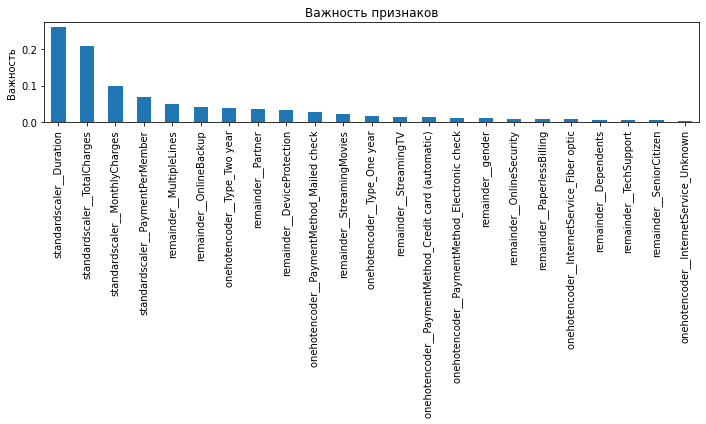

In [56]:
#Выведем диаграмму с оценкой влияния признаков на целевой

model_rf = gs_rf.best_estimator_._final_estimator
imp = pd.Series(model_rf.feature_importances_,
               pipline_rf[:-1].get_feature_names_out())

fig, ax = plt.subplots(figsize=(10,6))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Нелинейная модель дала другие важные признаки. Здесь большее значение имеет количество дней, когда клиент был активен и общая сумма платажей за весь период.

Далее обучим модель катбуст. здесь нет необходимости задавать пайплайн с трансформером, поскольку модель сама делает кодирование OHE.

In [57]:
#задаем категориальные признаки
cat_features = X_train.drop(num_features, axis=1).columns.to_list()

param_search = {'learning_rate': [0.1, 0.2, 0.3],
             'max_depth': [2, 6, 8, 10]}

#задаим постоянные параметры для модели CatBoost
params_cb = {'loss_function': 'Logloss',
             'eval_metric':  'AUC',
             'cat_features': cat_features,
              'n_estimators': 300,
              'random_seed': RANDOM_STATE,
              'verbose': False}

clf = CatBoostClassifier(**params_cb)

#определим модель
gs_cb = RandomizedSearchCV(estimator=clf, 
                       cv=3, 
                       param_distributions=param_search,  
                       refit='roc_auc_score',
                       random_state=RANDOM_STATE,
                       scoring=scorers)

gs_cb.fit(X_train, y_train)

gs_cb_best_score = gs_cb.best_score_ 
gs_cb_best_params = gs_cb.best_params_
print(f'best_score: {gs_cb_best_score}')
print(f'best_params: {gs_cb_best_params}')

best_score: 0.891735064787735
best_params: {'max_depth': 2, 'learning_rate': 0.3}


In [58]:
#сохраним результаты в таблице и выведем результаты
tadle_results_cb = results_gm(gs_cb)

tadle_results_cb

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
4,0.569,0.883,0.748,0.459
1,0.514,0.877,0.760,0.389
2,0.453,0.854,0.678,0.341
3,0.456,0.850,0.665,0.347
0,0.420,0.848,0.699,0.301


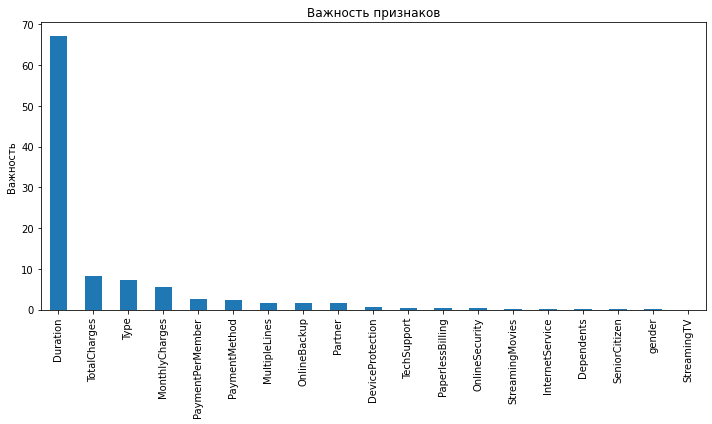

In [59]:
#Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(gs_cb.best_estimator_.feature_importances_,
               X_train.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Лучший показатель roc_auc из трех моделей дала модель катбуст.
Здесь также большее влияние на целевой признак оказывает количество дней, когда пользователь был клиентом оператора.

# Доработка модели

Попробуем обучить лучшую модель только на наиболее значимых признаках.

In [60]:
#выберем 8 самых важных фич для модели катбуст
features = imp.sort_values(ascending=False).index[:8]

cat_features2 = ['Type', 'PaymentMethod', 'PaymentMethod', 'MultipleLines']

X_train_imp = X_train[features]

#задаим постоянные параметры для модели CatBoost
params_cb_imp = {'loss_function': 'Logloss',
             'eval_metric':  'AUC',
             'cat_features': cat_features2,
              'n_estimators': 300,
              'random_seed': RANDOM_STATE,
              'verbose': False}

clf_imp = CatBoostClassifier(**params_cb_imp)

#определим модель
gs_cb_imp = RandomizedSearchCV(estimator=clf_imp, 
                       cv=3, 
                       param_distributions=param_search,  
                       refit='roc_auc_score',
                       random_state=RANDOM_STATE,
                       scoring=scorers)

gs_cb_imp.fit(X_train_imp, y_train)

gs_cb_best_score_imp = gs_cb_imp.best_score_ 
gs_cb_best_params_imp = gs_cb_imp.best_params_
print(f'best_score: {gs_cb_best_score_imp}')
print(f'best_params: {gs_cb_best_params_imp}')

best_score: 0.899862338080616
best_params: {'max_depth': 2, 'learning_rate': 0.3}


Метрики получаются лучше немного лучше для модели с отобранными признаками. Посмотрим как теперь распределы признаки по важности.

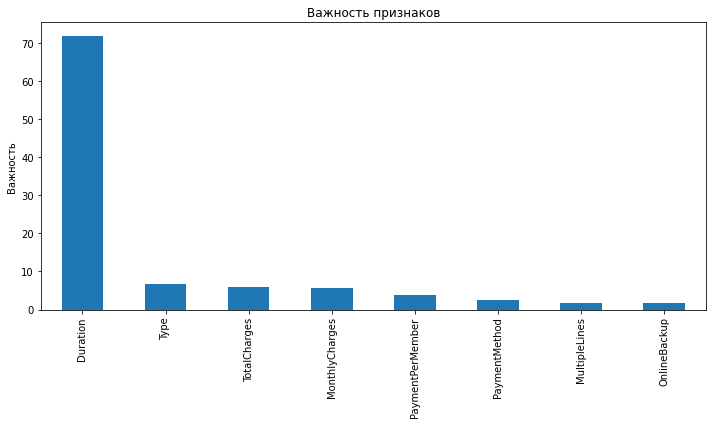

In [61]:
#Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(gs_cb_imp.best_estimator_.feature_importances_,
               X_train_imp.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Порядок фичей немного поменялся, но менее значимых признаков.

# Тестирование лучшей модели

In [68]:
#в результате обучения лучшие показатели дала модель катбуст
# выполним тестирование модели

model_test=gs_cb.best_estimator_

predicted_test = model_test.predict(X_test)

# вычислим вероятность положительного класса для всех моделей
probabilities_test = model_test.predict_proba(X_test)

#вычислим значение auc_roc
auc_roc_test = roc_auc_score(y_test, probabilities_test[:, 1])

print('AUC_ROC при тестировании:',"%.2f" % auc_roc_test)
print("F1 при тестировании:", "%.2f" % f1_score(y_test, predicted_test))
print("Точность при тестировании:", "%.2f" % precision_score(y_test, predicted_test))
print("Полнота при тестировании:", "%.2f" % recall_score(y_test, predicted_test))

AUC_ROC при тестировании: 0.92
F1 при тестировании: 0.63
Точность при тестировании: 0.94
Полнота при тестировании: 0.48


In [63]:
# выведем матрицу ошибок
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicted_test), 
                           index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1477,9
actual 1,144,131


Матрица ошибок показывает, что модель хорошо предсказывает отрицательные значения. Это значит, что ошибочно выданных прокодов клиентам, которые не собираются уходить, будет немного. Однако, ошибка второго рода в данном случае, довольно велика. Необходимо обратить внимание на метрику f1, это значение должно быть выше для модели, хорошо предсказывающей отток.

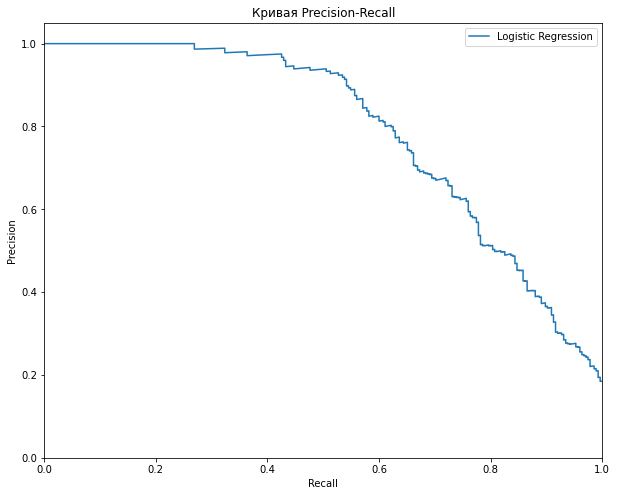

In [64]:
# посмотрим на изменение метрик полноты и точности при изменении порога классификации 
#для лучшей модели на тестовых данных

# вычислим значения точности, полноты и порога
precision, recall, thresholds = precision_recall_curve(y_test, 
                                                       probabilities_test[:, 1]) # Логистическая регрессия
# выведем графики изменения кривых по мере изменения порога 
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linestyle='-', label='Logistic Regression')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

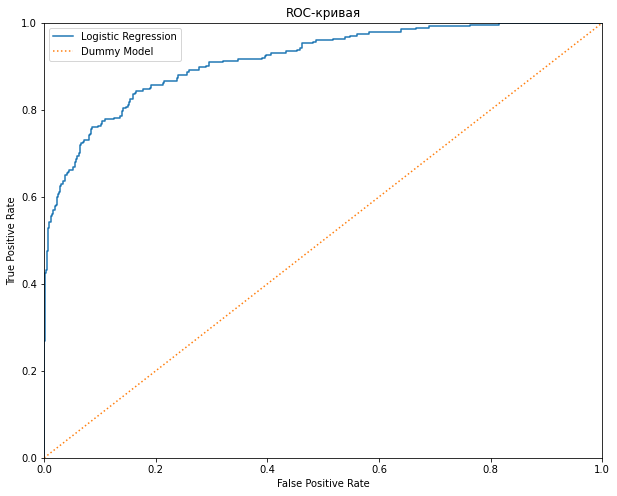

In [65]:
# посмотрим на кривую ошибок при изменении порога классификации
#для лучшей модели на тестовых данных

# вычислим значения ошибок и порога
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test[:, 1])

# выведем графики кривой ошибок для всех моделей
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle='-', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle=':', label='Dummy Model') # добавим график для случаной модели
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

ROC- кривые показывают отношение ложноположительных ответов (FPR) и истинно положительных ответов (TPR) по мере изменения порога классификации. Для оценки качества модели используется площадь под соотвествующей кривой - метрика AUC-ROC. Судя по характеру кривой ошибок и площади под кривой, качество предсказаний для модели на тестовых данных достаточно высоко. 

# Выводы

В результате исследования достигнута цель и выполнена задача проекта - построена модель машинного обучения, способная достаточно точно предсказать намерение клиента отказаться от услуг оператора.

Лушие результаты показала модель Catboost - AUC-ROC = 0.92.

В ходе работы над проектом выполнены следующие этапы и получены результаты:
1. Данные загружены и исследованы;
2. Выполнена данных:
    - данные преобразованы;
    - сгенерированы синтетические признаки;
    - исследованы аномалии.
3. Выполнен исследовательский анализ данных
   - обнаружен дисбаланс целевого признака;
   - составлен портрет пользователя, решившего откаться от услуг оператора.
4. Выполнено обучение моделей и получены результаты:
   - Логистическая регрессия: AUC-ROC = 0.77;
   - Случайный лес: AUC-ROC = 0.82;
   - Catboost: AUC-ROC = 0.89;
5. Протестирована лучшая модель Catboost: AUC-ROC = 0.92.
